In [1]:
import geopandas as gpd
import pandas as pd
import json
import os
import json
import numpy as np
from pathlib import Path
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

import rasterio
from shapely.geometry import box, mapping
import matplotlib.pyplot as plt
import rasterio.plot  
from shapely.ops import transform
from pyproj import CRS

# custom functions
import sys
sys.path.append('../')
from utils.tiling import split_geotiff, reproject, split_annotations_to_geojson

In [2]:
### 1. Split geotiff args ###

raster_folder = Path("../Satellite/big_tiles_test")
tile_output_folder = Path("../Satellite/small_tiles_test")

#make output directory if does not exist
if not os.path.exists(tile_output_folder):
    os.makedirs(tile_output_folder)

#details of small tiles
width = 1000 #width of the new tiles
height = 1000 #height of the new tiles
nso_pix = 1 #pixel size of the raster

### 2. Reproject geodataframe of a annotation shapefile args ###

annotations_crs = "epsg:4326"
raster_crs = "epsg:3857"


### 3.Spit annotations args ###

# Make folder for geojsons
json_folder = Path("../Satellite/geojsons_test")
if not os.path.exists(json_folder):
    os.makedirs(json_folder)

In [3]:
### 1. Spliting a list of raster into several tiles of x width and y height skipping black tiles ###
##Find this function in utils --> tiling.py 

#loop through the big tiles (rasters) and split them into smaller tiles
split_geotiff(raster_folder, tile_output_folder, width, height, nso_pix)



100%|██████████| 3/3 [01:30<00:00, 30.17s/it]


In [4]:
### Reproject the DataFrame of an annotation CRS to the target CRS as the raster tiles ###

# Define the directory containing your GeoJSON files
annotations_path = '../Satellite/geojsons_test'
output_path = '../Satellite/geojsons_test_converted'

# Define the source and target CRS
annotations_crs = "epsg:4326"
raster_crs = "epsg:3857"

for filename in os.listdir(annotations_path):
        if filename.endswith(".geojson"):
            file_path = os.path.join(annotations_path, filename)
            gdf = gpd.read_file(file_path)

            if gdf.crs is None:
                gdf.set_crs(annotations_crs, inplace=True)
            
            # Ensuring type information is present
            if 'type' in gdf.columns:
                gdf = gdf.to_crs(raster_crs)
                output_file_path = os.path.join(output_path, f"reprojected_{filename}")
                gdf.to_file(output_file_path, driver='GeoJSON')
            else:
                print(f"No 'type' column found in {filename}")

print("Reprojection completed.")


Reprojection completed.


In [5]:
### Put all the geojsons in one dataframe

def load_geojson_files(directory):
    """
    Load all GeoJSON files from a directory into a single GeoDataFrame.

    Args:
    directory (str): Path to the directory containing the GeoJSON files.

    Returns:
    GeoDataFrame: A GeoDataFrame containing all the features from the GeoJSON files.
    """
    geojson_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.geojson')]
    geojson_dfs = [gpd.read_file(geojson_file) for geojson_file in geojson_files]
    combined_gdf = gpd.GeoDataFrame(pd.concat(geojson_dfs, ignore_index=True))
    return combined_gdf

# Path to the directory containing the GeoJSON files
geojson_directory = '../Satellite/geojsons_test'

# Load the GeoJSON files into a single GeoDataFrame
df = load_geojson_files(geojson_directory)
print(df)

    port_name  country       continent          area      type     sector  \
0     Antwerp  Belgium  Western-Europe  2.320782e+05     mixed  Transport   
1     Antwerp  Belgium  Western-Europe  5.808601e+05     mixed  Transport   
2     Antwerp  Belgium  Western-Europe  2.466609e+05     mixed  Transport   
3     Antwerp  Belgium  Western-Europe  5.340470e+05     mixed  Transport   
4     Antwerp  Belgium  Western-Europe  7.124226e+05     mixed  Transport   
..        ...      ...             ...           ...       ...        ...   
203     Ghent  Belgium  Western-Europe  1.076404e+05  refinery          7   
204     Ghent  Belgium  Western-Europe  3.219809e+06  industry          8   
205     Ghent  Belgium  Western-Europe  1.576383e+06  industry          9   
206     Ghent  Belgium  Western-Europe  1.979718e+06  industry         10   
207     Ghent  Belgium  Western-Europe  2.759742e+06  industry         10   

          land_use                                           geometry  
0  

In [7]:
### Split annotations DataFrame into the new small tiles of width X and height Y & save it to geojson ###
### THIS IS WHERE PROBLEM MIGHT BE 


def split_geojson_annotations(tiles_directory, annotations_directory, output_directory, pixel_size):
    """
    This function splits the annotations in .geojson files to match the pre-split tiles.

    Parameters:
    tiles_directory (str): File path to the folder with the pre-split raster tiles.
    annotations_directory (str): File path to the folder with the annotations (.geojson).
    output_directory (str): File path to the folder where the split annotations will be saved.
    pixel_size (float): Pixel size of the raster.

    Returns:
    tuple: DataFrames with and without annotations, and a list of annotation files.
    """

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    annotation_files = [f for f in os.listdir(annotations_directory) if f.endswith('.geojson')]
    tiles_with_annotations = []
    tiles_without_annotations = []
    
    # Process each tile
    for tile_filename in tqdm(os.listdir(tiles_directory)):
        if tile_filename.endswith('.tif'):
            tile_path = os.path.join(tiles_directory, tile_filename)
            with rasterio.open(tile_path) as tile:
                annotations_found = False

                # Loop through each annotation file
                for annotation_filename in annotation_files:
                    annotations_path = os.path.join(annotations_directory, annotation_filename)
                    annotations = gpd.read_file(annotations_path)
                    
                    if annotations.crs != tile.crs:
                        transformed_annotations = annotations.to_crs(tile.crs)
                    else:
                        transformed_annotations = annotations

                    tile_geom = box(*tile.bounds)
                    tile_gdf = gpd.GeoDataFrame([1], geometry=[tile_geom], crs=tile.crs)
                    intersection = gpd.overlay(transformed_annotations, tile_gdf, how='intersection')

                    if not intersection.empty:
                        annotations_found = True

                        # Prepare intersected annotations for saving
                        new_features = []
                        for _, row in intersection.iterrows():
                            new_feature = {
                                "type": "Feature",
                                "geometry": mapping(row['geometry']),
                                "properties": row.drop('geometry').to_dict()
                            }
                            new_features.append(new_feature)
                        
                        new_annotations = {
                            "type": "FeatureCollection",
                            "features": new_features
                        }

                        output_annotation_path = os.path.join(output_directory, "{}.geojson".format(tile_filename.split('.')[0]))
                        
                        print(f"Creating annotation file: {output_annotation_path}")  # Debug statement

                        with open(output_annotation_path, 'w') as out_f:
                            json.dump(new_annotations, out_f, indent=2)
                        
                        break  # Stop checking other annotation files if one match is found

                if annotations_found:
                    tiles_with_annotations.append(tile_filename)
                else:
                    tiles_without_annotations.append(tile_filename)

    # Create DataFrames from the lists
    df_annot = pd.DataFrame(tiles_with_annotations, columns=['Tile_Name'])
    df_empty_annot = pd.DataFrame(tiles_without_annotations, columns=['Tile_Name'])

    # Optionally, print the DataFrames
    print("Tiles with annotations:")
    print(df_annot)
    print("Tiles without annotations:")
    print(df_empty_annot)

    return df_annot, df_empty_annot, annotation_files

# Define your paths
tiles_directory = '../Satellite/small_tiles_test'  
annotations_directory = '../Satellite/geojsons_test'  
output_directory = '../Satellite/split_geojsons_test'  
pixel_size = 1.0  

# Run the function and store DataFrames
df_annot, df_empty_annot, annotation_files = split_geojson_annotations(tiles_directory, annotations_directory, output_directory, pixel_size)

# Display the first few rows of each DataFrame
print("DataFrame with no annotations:")
print(df_empty_annot.head())
print("\nDataFrame with annotations:")
print(df_annot.head())




  0%|          | 4/1205 [00:00<01:15, 15.86it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_0.geojson


  1%|          | 8/1205 [00:00<01:23, 14.35it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_14000.geojson


  1%|▏         | 18/1205 [00:01<01:14, 15.91it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_19000.geojson


  2%|▏         | 26/1205 [00:01<01:12, 16.25it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_14000.geojson


  3%|▎         | 32/1205 [00:02<01:14, 15.72it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_24000.geojson


  3%|▎         | 40/1205 [00:02<01:03, 18.41it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_20000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_11000.geojson


  4%|▍         | 48/1205 [00:03<01:06, 17.51it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_20000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_3000.geojson


  4%|▍         | 52/1205 [00:03<01:10, 16.32it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_12000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_16000.geojson


  4%|▍         | 54/1205 [00:03<01:09, 16.67it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_8000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_15000_11000.geojson


  5%|▍         | 60/1205 [00:03<01:13, 15.51it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_2000.geojson


  5%|▌         | 66/1205 [00:04<01:19, 14.32it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_12000_13000.geojson


  6%|▌         | 72/1205 [00:04<01:18, 14.48it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_0_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_10000_7000.geojson


  6%|▋         | 78/1205 [00:05<01:14, 15.10it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_6000.geojson


  7%|▋         | 84/1205 [00:05<01:08, 16.31it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_6000.geojson


  7%|▋         | 90/1205 [00:05<01:12, 15.45it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_14000.geojson


  8%|▊         | 97/1205 [00:06<01:01, 18.02it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_9000.geojson


  9%|▊         | 103/1205 [00:06<01:07, 16.30it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_22000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_23000.geojson


  9%|▉         | 109/1205 [00:06<01:09, 15.74it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_10000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_7000.geojson


 10%|█         | 121/1205 [00:07<01:17, 13.98it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_7000.geojson


 10%|█         | 125/1205 [00:08<01:08, 15.83it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_13000.geojson


 11%|█         | 133/1205 [00:08<01:13, 14.60it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_11000_13000.geojson


 11%|█▏        | 137/1205 [00:08<01:09, 15.36it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_23000.geojson


 12%|█▏        | 143/1205 [00:09<01:08, 15.55it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_16000.geojson


 12%|█▏        | 149/1205 [00:09<01:14, 14.25it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_22000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_4000.geojson


 13%|█▎        | 157/1205 [00:10<01:07, 15.41it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_22000.geojson


 14%|█▎        | 163/1205 [00:10<01:09, 14.99it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_13000.geojson


 14%|█▎        | 165/1205 [00:10<01:05, 15.77it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_10000.geojson


 14%|█▍        | 171/1205 [00:11<01:07, 15.40it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_10000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_16000.geojson


 14%|█▍        | 173/1205 [00:11<01:04, 16.10it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_13000.geojson


 15%|█▌        | 181/1205 [00:11<01:06, 15.39it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_11000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_11000.geojson


 15%|█▌        | 185/1205 [00:12<01:10, 14.41it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_12000_7000.geojson


 16%|█▌        | 191/1205 [00:12<01:03, 15.85it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_8000.geojson


 16%|█▌        | 195/1205 [00:12<01:05, 15.43it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_4000_5000.geojson


 17%|█▋        | 199/1205 [00:12<01:09, 14.52it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_6000_12000.geojson


 17%|█▋        | 205/1205 [00:13<01:11, 14.03it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_12000_11000.geojson


 18%|█▊        | 211/1205 [00:13<01:08, 14.58it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_8000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_15000_13000.geojson


 18%|█▊        | 215/1205 [00:14<01:04, 15.31it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_14000.geojson


 18%|█▊        | 221/1205 [00:14<00:59, 16.40it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_22000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_9000.geojson


 19%|█▉        | 229/1205 [00:14<00:58, 16.55it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_5000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_16000.geojson


 20%|█▉        | 237/1205 [00:15<00:59, 16.40it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_10000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_21000.geojson


 20%|██        | 241/1205 [00:15<01:05, 14.80it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_4000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_22000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_5000.geojson


 20%|██        | 247/1205 [00:16<01:00, 15.89it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_9000.geojson


 21%|██        | 253/1205 [00:16<00:58, 16.14it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_0_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_8000.geojson


 21%|██▏       | 257/1205 [00:16<00:55, 16.98it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_18000.geojson


 22%|██▏       | 261/1205 [00:16<00:57, 16.47it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_23000_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_4000.geojson


 22%|██▏       | 269/1205 [00:17<01:01, 15.18it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_14000.geojson


 22%|██▏       | 271/1205 [00:17<01:03, 14.66it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_18000.geojson


 23%|██▎       | 278/1205 [00:18<00:53, 17.26it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_10000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_6000.geojson


 23%|██▎       | 282/1205 [00:18<01:00, 15.28it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_3000.geojson


 24%|██▎       | 286/1205 [00:18<00:58, 15.60it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_14000.geojson


 24%|██▍       | 293/1205 [00:19<00:57, 15.82it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_2000_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_5000_12000.geojson


 25%|██▍       | 299/1205 [00:19<01:00, 14.97it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_3000_2000.geojson


 25%|██▍       | 301/1205 [00:19<01:02, 14.56it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_11000_11000.geojson


 26%|██▌       | 308/1205 [00:20<00:55, 16.04it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_5000.geojson


 26%|██▌       | 315/1205 [00:20<00:48, 18.19it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_0_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_18000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_10000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_4000_3000.geojson


 27%|██▋       | 321/1205 [00:20<00:58, 15.15it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_6000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_27000.geojson


 27%|██▋       | 325/1205 [00:21<00:53, 16.41it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_12000.geojson


 27%|██▋       | 331/1205 [00:21<00:52, 16.78it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_12000.geojson


 28%|██▊       | 339/1205 [00:21<00:52, 16.51it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_24000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_20000.geojson


 28%|██▊       | 343/1205 [00:22<00:49, 17.33it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_15000.geojson


 29%|██▉       | 349/1205 [00:22<00:50, 17.06it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_20000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_24000.geojson


 29%|██▉       | 353/1205 [00:22<00:52, 16.16it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_12000.geojson


 30%|██▉       | 361/1205 [00:23<00:55, 15.09it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_24000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_15000.geojson


 30%|███       | 367/1205 [00:23<00:51, 16.16it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_18000.geojson


 31%|███       | 375/1205 [00:24<00:56, 14.72it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_4000_0.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_14000.geojson


 32%|███▏      | 381/1205 [00:24<00:54, 15.16it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_10000_15000.geojson


 32%|███▏      | 385/1205 [00:24<00:53, 15.25it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_1000_6000.geojson


 32%|███▏      | 389/1205 [00:25<00:53, 15.31it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_12000.geojson


 33%|███▎      | 395/1205 [00:25<00:52, 15.37it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_0.geojson


 33%|███▎      | 400/1205 [00:25<00:46, 17.29it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_2000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_2000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_20000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_3000_4000.geojson


 34%|███▎      | 404/1205 [00:26<00:48, 16.55it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_3000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_5000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_3000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_27000.geojson


 34%|███▍      | 409/1205 [00:26<00:48, 16.38it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_18000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_22000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_13000.geojson


 34%|███▍      | 414/1205 [00:26<00:44, 17.68it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_1000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_17000.geojson


 35%|███▍      | 420/1205 [00:27<00:52, 15.04it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_3000.geojson


 35%|███▌      | 424/1205 [00:27<00:51, 15.11it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_3000.geojson


 36%|███▌      | 430/1205 [00:27<00:47, 16.16it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_27000.geojson


 36%|███▌      | 432/1205 [00:27<00:46, 16.63it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_2000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_4000_14000.geojson


 36%|███▌      | 436/1205 [00:28<00:48, 15.82it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_1000_6000.geojson


 37%|███▋      | 442/1205 [00:28<00:46, 16.53it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_13000.geojson


 37%|███▋      | 448/1205 [00:28<00:45, 16.57it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_18000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_20000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_2000.geojson


 38%|███▊      | 452/1205 [00:29<00:44, 17.10it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_2000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_9000.geojson


 38%|███▊      | 460/1205 [00:29<00:44, 16.59it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_12000.geojson


 39%|███▊      | 465/1205 [00:29<00:43, 17.04it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_18000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_17000.geojson


 39%|███▉      | 473/1205 [00:30<00:44, 16.54it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_8000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_1000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_10000.geojson


 40%|███▉      | 477/1205 [00:30<00:45, 15.95it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_5000.geojson


 40%|████      | 485/1205 [00:31<00:45, 15.76it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_0_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_6000_16000.geojson


 41%|████      | 489/1205 [00:31<00:48, 14.63it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_12000.geojson


 41%|████      | 495/1205 [00:31<00:45, 15.74it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_4000_1000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_15000.geojson


 41%|████▏     | 499/1205 [00:32<00:49, 14.40it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_3000_0.geojson


 42%|████▏     | 503/1205 [00:32<00:47, 14.70it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_16000.geojson


 42%|████▏     | 510/1205 [00:32<00:43, 16.16it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_6000.geojson


 43%|████▎     | 515/1205 [00:33<00:40, 16.87it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_18000.geojson


 43%|████▎     | 521/1205 [00:33<00:40, 16.96it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_10000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_12000.geojson


 44%|████▎     | 525/1205 [00:33<00:38, 17.49it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_28000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_14000.geojson


 44%|████▍     | 531/1205 [00:34<00:37, 17.87it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_22000.geojson


 44%|████▍     | 535/1205 [00:34<00:39, 16.87it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_1000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_15000.geojson


 45%|████▍     | 539/1205 [00:34<00:40, 16.40it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_3000.geojson


 45%|████▌     | 543/1205 [00:34<00:44, 14.92it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_18000_6000.geojson


 45%|████▌     | 547/1205 [00:35<00:43, 14.99it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_5000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_3000_6000.geojson


 46%|████▌     | 549/1205 [00:35<00:45, 14.50it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_7000.geojson


 46%|████▌     | 555/1205 [00:35<00:40, 16.00it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_28000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_10000.geojson


 46%|████▋     | 559/1205 [00:35<00:43, 14.70it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_7000.geojson


 47%|████▋     | 563/1205 [00:36<00:40, 16.05it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_2000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_15000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_18000.geojson


 47%|████▋     | 570/1205 [00:36<00:38, 16.54it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_28000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_10000.geojson


 48%|████▊     | 579/1205 [00:37<00:38, 16.43it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_18000.geojson


 48%|████▊     | 583/1205 [00:37<00:39, 15.90it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_12000.geojson


 49%|████▊     | 587/1205 [00:37<00:36, 16.95it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_1000_9000.geojson


 49%|████▉     | 593/1205 [00:38<00:40, 15.29it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_1000_4000.geojson


 50%|████▉     | 601/1205 [00:38<00:40, 15.05it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_4000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_20000.geojson


 50%|█████     | 607/1205 [00:38<00:39, 14.99it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_1000.geojson


 51%|█████     | 611/1205 [00:39<00:39, 15.16it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_16000.geojson


 51%|█████▏    | 619/1205 [00:39<00:35, 16.46it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_30000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_2000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_9000.geojson


 52%|█████▏    | 623/1205 [00:39<00:36, 16.13it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_2000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_4000_15000.geojson


 52%|█████▏    | 629/1205 [00:40<00:37, 15.23it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_18000_8000.geojson


 53%|█████▎    | 633/1205 [00:40<00:36, 15.68it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_13000.geojson


 53%|█████▎    | 639/1205 [00:41<00:37, 15.04it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_14000.geojson


 54%|█████▎    | 645/1205 [00:41<00:37, 15.01it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_14000.geojson


 54%|█████▎    | 647/1205 [00:41<00:38, 14.33it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_14000.geojson


 54%|█████▍    | 653/1205 [00:41<00:34, 15.91it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_2000_9000.geojson


 55%|█████▍    | 657/1205 [00:42<00:33, 16.56it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_2000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_10000_14000.geojson


 55%|█████▌    | 666/1205 [00:42<00:30, 17.41it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_1000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_1000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_16000.geojson


 56%|█████▌    | 674/1205 [00:43<00:33, 15.80it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_2000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_26000.geojson


 56%|█████▋    | 678/1205 [00:43<00:31, 16.90it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_3000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_5000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_3000_11000.geojson


 57%|█████▋    | 684/1205 [00:43<00:34, 15.26it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_3000_5000.geojson


 57%|█████▋    | 686/1205 [00:44<00:35, 14.74it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_18000_5000.geojson


 57%|█████▋    | 692/1205 [00:44<00:33, 15.24it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_0.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_11000.geojson


 58%|█████▊    | 696/1205 [00:44<00:32, 15.67it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_14000.geojson


 58%|█████▊    | 702/1205 [00:45<00:30, 16.46it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_21000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_14000.geojson


 59%|█████▉    | 708/1205 [00:45<00:32, 15.45it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_30000.geojson


 59%|█████▉    | 710/1205 [00:45<00:33, 14.86it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_11000.geojson


 59%|█████▉    | 714/1205 [00:45<00:34, 14.31it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_15000.geojson


 60%|█████▉    | 721/1205 [00:46<00:28, 17.04it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_19000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_0_6000.geojson


 60%|██████    | 725/1205 [00:46<00:29, 16.52it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_26000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_6000_15000.geojson


 60%|██████    | 729/1205 [00:46<00:31, 14.99it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_11000.geojson


 61%|██████    | 733/1205 [00:47<00:30, 15.53it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_7000.geojson


 61%|██████    | 735/1205 [00:47<00:28, 16.24it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_19000.geojson


 61%|██████▏   | 739/1205 [00:47<00:29, 15.67it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_4000_2000.geojson


 62%|██████▏   | 744/1205 [00:47<00:28, 16.28it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_5000_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_14000.geojson


 63%|██████▎   | 754/1205 [00:48<00:27, 16.54it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_6000.geojson


 63%|██████▎   | 761/1205 [00:48<00:26, 16.71it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_19000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_13000.geojson


 64%|██████▍   | 769/1205 [00:49<00:25, 16.97it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_29000.geojson


 65%|██████▍   | 783/1205 [00:50<00:27, 15.15it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_4000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_24000.geojson


 66%|██████▌   | 791/1205 [00:50<00:27, 14.93it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_14000.geojson


 66%|██████▌   | 796/1205 [00:51<00:25, 15.93it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_0.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_1000_5000.geojson


 66%|██████▋   | 800/1205 [00:51<00:26, 15.44it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_1000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_18000_7000.geojson


 67%|██████▋   | 806/1205 [00:51<00:26, 15.27it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_11000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_24000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_5000_17000.geojson


 68%|██████▊   | 816/1205 [00:52<00:24, 15.93it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_2000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_14000.geojson


 68%|██████▊   | 820/1205 [00:52<00:24, 15.57it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_15000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_3000.geojson


 69%|██████▊   | 826/1205 [00:53<00:23, 15.83it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_19000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_1000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_2000_6000.geojson


 69%|██████▉   | 832/1205 [00:53<00:22, 16.56it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_29000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_6000.geojson


 69%|██████▉   | 837/1205 [00:53<00:21, 17.09it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_7000.geojson


 70%|███████   | 847/1205 [00:54<00:23, 15.08it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_13000.geojson


 71%|███████   | 851/1205 [00:54<00:23, 15.36it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_15000.geojson


 71%|███████   | 856/1205 [00:54<00:20, 17.42it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_29000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_23000.geojson


 72%|███████▏  | 862/1205 [00:55<00:19, 17.86it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_19000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_13000.geojson


 72%|███████▏  | 868/1205 [00:55<00:20, 16.58it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_10000_6000.geojson


 73%|███████▎  | 875/1205 [00:56<00:19, 16.72it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_11000.geojson


 73%|███████▎  | 881/1205 [00:56<00:19, 16.89it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_8000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_13000.geojson


 74%|███████▎  | 887/1205 [00:56<00:18, 16.94it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_19000.geojson


 74%|███████▍  | 895/1205 [00:57<00:18, 16.61it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_5000.geojson


 75%|███████▍  | 899/1205 [00:57<00:20, 15.03it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_11000.geojson


 75%|███████▍  | 903/1205 [00:57<00:20, 14.78it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_0_4000.geojson


 76%|███████▌  | 913/1205 [00:58<00:19, 14.62it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_22000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_5000_11000.geojson


 76%|███████▌  | 917/1205 [00:58<00:19, 14.59it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_3000_1000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_11000_12000.geojson


 76%|███████▋  | 921/1205 [00:59<00:20, 14.05it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_6000.geojson


 77%|███████▋  | 927/1205 [00:59<00:17, 15.77it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_0.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_4000.geojson


 77%|███████▋  | 929/1205 [00:59<00:16, 16.37it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_16000.geojson


 78%|███████▊  | 935/1205 [01:00<00:18, 14.45it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_7000.geojson


 78%|███████▊  | 939/1205 [01:00<00:19, 13.94it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_22000_9000.geojson


 79%|███████▊  | 946/1205 [01:00<00:16, 15.86it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_9000.geojson


 79%|███████▉  | 950/1205 [01:01<00:16, 15.87it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_22000_15000.geojson


 80%|███████▉  | 958/1205 [01:01<00:16, 14.94it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_7000.geojson


 80%|███████▉  | 962/1205 [01:01<00:15, 15.38it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_23000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_10000_12000.geojson


 80%|████████  | 968/1205 [01:02<00:14, 16.35it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_22000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_6000.geojson


 81%|████████  | 975/1205 [01:02<00:13, 17.54it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_16000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_12000.geojson


 81%|████████▏ | 980/1205 [01:02<00:13, 17.05it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_1000_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_8000.geojson


 82%|████████▏ | 986/1205 [01:03<00:12, 16.89it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_21000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_15000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_8000_13000.geojson


 82%|████████▏ | 994/1205 [01:03<00:12, 16.53it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_2000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_10000.geojson


 83%|████████▎ | 998/1205 [01:04<00:13, 15.76it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_11000_7000.geojson


 83%|████████▎ | 1004/1205 [01:04<00:12, 15.60it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_12000.geojson


 84%|████████▎ | 1008/1205 [01:04<00:12, 15.75it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_3000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_8000.geojson


 84%|████████▍ | 1014/1205 [01:05<00:13, 14.43it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_6000_11000.geojson


 84%|████████▍ | 1016/1205 [01:05<00:13, 14.14it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_12000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_15000.geojson


 85%|████████▌ | 1026/1205 [01:06<00:11, 15.83it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_18000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_9000.geojson


 85%|████████▌ | 1030/1205 [01:06<00:11, 14.63it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_12000.geojson


 86%|████████▌ | 1032/1205 [01:06<00:12, 14.31it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_11000.geojson


 86%|████████▋ | 1042/1205 [01:07<00:10, 15.78it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_21000.geojson


 87%|████████▋ | 1050/1205 [01:07<00:10, 15.00it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_12000_10000.geojson


 87%|████████▋ | 1054/1205 [01:07<00:10, 15.10it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_21000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_19000_2000.geojson


 88%|████████▊ | 1060/1205 [01:08<00:08, 16.17it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_15000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_16000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_9000.geojson


 88%|████████▊ | 1062/1205 [01:08<00:08, 16.19it/s]

Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_2000_2000.geojson


 89%|████████▊ | 1068/1205 [01:08<00:08, 15.70it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_10000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_19000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_7000.geojson


 89%|████████▉ | 1075/1205 [01:09<00:07, 17.66it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_14000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_6000.geojson


 90%|█████████ | 1085/1205 [01:09<00:07, 15.95it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_3000_3000.geojson


 91%|█████████ | 1091/1205 [01:10<00:07, 15.40it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_5000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_18000_3000.geojson


 91%|█████████▏| 1101/1205 [01:10<00:07, 14.63it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_21000_8000.geojson


 92%|█████████▏| 1105/1205 [01:11<00:06, 14.93it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_16000_4000.geojson


 92%|█████████▏| 1111/1205 [01:11<00:06, 14.04it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_22000_6000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_4000_13000.geojson


 93%|█████████▎| 1115/1205 [01:11<00:05, 15.75it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_20000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_4000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_10000_10000.geojson


 93%|█████████▎| 1119/1205 [01:12<00:05, 15.78it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_23000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_5000.geojson


 93%|█████████▎| 1125/1205 [01:12<00:04, 16.36it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_17000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_17000_5000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_5000_15000.geojson


 94%|█████████▍| 1131/1205 [01:12<00:05, 14.46it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_20000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_0_7000.geojson


 94%|█████████▍| 1136/1205 [01:13<00:04, 16.71it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_19000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_11000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_12000_10000.geojson


 95%|█████████▍| 1144/1205 [01:13<00:03, 15.51it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_6000_13000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_1000.geojson


 96%|█████████▌| 1152/1205 [01:14<00:03, 15.60it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_9000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_10000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_4000_4000.geojson


 96%|█████████▌| 1157/1205 [01:14<00:02, 17.50it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_4000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_13000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/3_Valencia_5000_5000.geojson


 97%|█████████▋| 1163/1205 [01:14<00:02, 16.06it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_9000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_14000_0.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_8000_9000.geojson


 97%|█████████▋| 1167/1205 [01:15<00:02, 16.99it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_20000_17000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_7000_15000.geojson


 97%|█████████▋| 1171/1205 [01:15<00:02, 16.07it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_8000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_19000_23000.geojson


 97%|█████████▋| 1174/1205 [01:15<00:01, 17.47it/s]

Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_6000.geojson


 98%|█████████▊| 1180/1205 [01:16<00:01, 14.94it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_10000_9000.geojson


 99%|█████████▊| 1189/1205 [01:16<00:01, 15.94it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_7000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_18000_23000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_9000_11000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_14000_12000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_6000_15000.geojson


 99%|█████████▉| 1195/1205 [01:17<00:00, 14.97it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_7000_13000.geojson


100%|█████████▉| 1199/1205 [01:17<00:00, 14.26it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_13000_10000.geojson


100%|██████████| 1205/1205 [01:17<00:00, 15.51it/s]

Creating annotation file: ../Satellite/split_geojsons_test/1_Ghent_11000_8000.geojson
Creating annotation file: ../Satellite/split_geojsons_test/2_Antwerp_15000_10000.geojson
Tiles with annotations:
                     Tile_Name
0       1_Ghent_7000_10000.tif
1        2_Antwerp_17000_0.tif
2      1_Ghent_13000_13000.tif
3       1_Ghent_8000_14000.tif
4    2_Antwerp_15000_13000.tif
..                         ...
444   2_Antwerp_6000_15000.tif
445     1_Ghent_7000_13000.tif
446    1_Ghent_13000_10000.tif
447     1_Ghent_11000_8000.tif
448  2_Antwerp_15000_10000.tif

[449 rows x 1 columns]
Tiles without annotations:
                     Tile_Name
0     2_Antwerp_1000_14000.tif
1       1_Ghent_12000_5000.tif
2        1_Ghent_4000_9000.tif
3      2_Antwerp_6000_8000.tif
4    2_Antwerp_11000_30000.tif
..                         ...
751   2_Antwerp_4000_22000.tif
752      1_Ghent_8000_4000.tif
753   2_Antwerp_11000_3000.tif
754      1_Ghent_7000_4000.tif
755    2_Antwerp_5000_5000.tif

[756 

In [ ]:
### The function that Joel uses to split the annotations 
### Split annotations (shapefile) DataFrame into the new small tiles of width X and height Y & save it to geojson ###
# Find this function utils --> tiling
# My files are already in geojson so I just want to split them

#split_annotations_to_geojson(df, tile_output_folder, json_folder)

Example tile path: ../Satellite/small_tiles_test/1_Ghent_7000_10000.tif
Example annotation path: ../Satellite/split_geojsons_test/1_Ghent_7000_10000.geojson


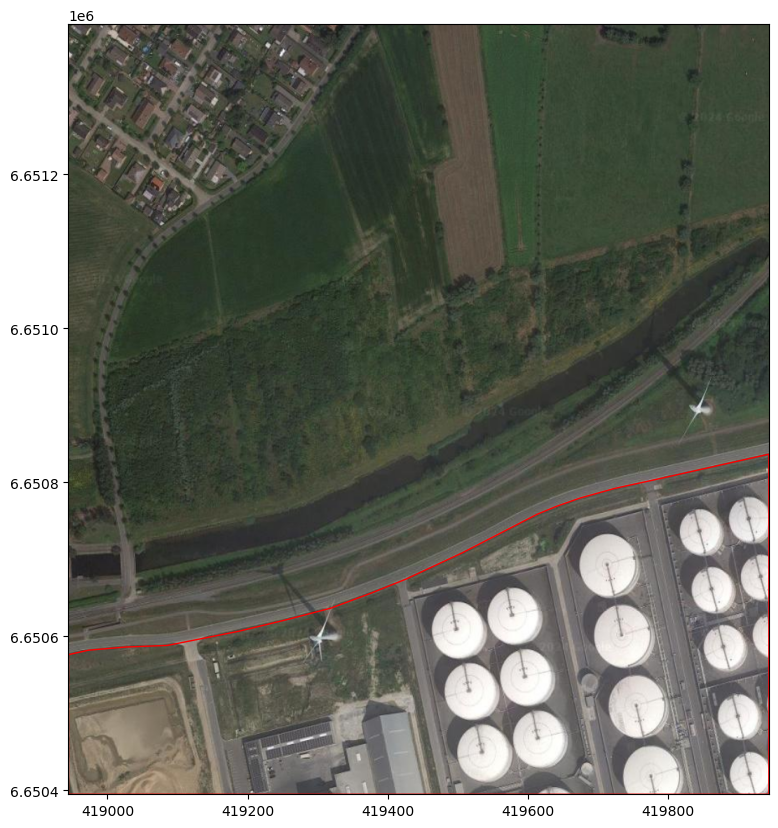

In [8]:
### Plot a small tile with its corresponding annotation

def plot_tile_with_annotation(tile_path, annotation_path):
    if not os.path.exists(tile_path):
        print(f"Tile not found: {tile_path}")
        return
    if not os.path.exists(annotation_path):
        print(f"Annotation not found: {annotation_path}")
        return
    
    with rasterio.open(tile_path) as tile:
        fig, ax = plt.subplots(figsize=(10, 10))
        rasterio.plot.show(tile, ax=ax)
        annotations = gpd.read_file(annotation_path)
        annotations.plot(ax=ax, facecolor='none', edgecolor='red')
        plt.show()

if not df_annot.empty:
    example_tile = os.path.join(tiles_directory, df_annot['Tile_Name'].iloc[0])
    annotation_filename = "{}.geojson".format(df_annot['Tile_Name'].iloc[0].split('.')[0])
    example_annotation = os.path.join(output_directory, annotation_filename)
    print(f"Example tile path: {example_tile}")
    print(f"Example annotation path: {example_annotation}")
    plot_tile_with_annotation(example_tile, example_annotation)
else:
    print("No tiles with annotations found.")



In [9]:
###Extract labels of land uses and print unique types 

def print_unique_types(annotations_path):
    unique_types = set()  # Using a set to avoid duplicate types

    # Check all GeoJSON files in the given directory
    for filename in os.listdir(annotations_path):
        if filename.endswith(".geojson"):
            file_path = os.path.join(annotations_path, filename)
            try:
                # Load the GeoJSON file into a GeoDataFrame
                gdf = gpd.read_file(file_path)
                
                # Check if 'type' column exists in the GeoDataFrame
                if 'type' in gdf.columns:
                    # Update the set with unique types found in this file
                    unique_types.update(gdf['type'].unique())
                else:
                    print(f"No 'type' column found in {filename}")
            except Exception as e:
                print(f"Failed to process {filename}: {e}")

    # Print all unique types collected from all files
    print("Unique types found:")
    for typ in unique_types:
        print(typ)

annotations_path =  Path("../Satellite/geojsons_test")
print_unique_types(annotations_path)


Unique types found:
roro
warehouse
land
wood
container
storage
raw
scrap
refinery
other
bulk
steel
vehicles
mixed
oil/gas
industry
break


In [ ]:
###Looks for which files contain a certain type, I used this for visually examining the tiles 

# import os
# import json

# def get_files_with_wood_annotation(geojson_dir, target_type='bulk'):
#     files_with_wood = []

#     for filename in os.listdir(geojson_dir):
#         if filename.endswith('.geojson'):
#             file_path = os.path.join(geojson_dir, filename)
#             with open(file_path) as f:
#                 data = json.load(f)

#             for feature in data['features']:
#                 if 'properties' in feature and 'type' in feature['properties']:
#                     if feature['properties']['type'] == target_type:
#                         files_with_wood.append(filename)
#                         break  # Move to the next file once we find 'wood' in the current one

#     return files_with_wood

# # Example usage
# geojson_dir = "../Satellite/geojsons"
# files_with_wood = get_files_with_wood_annotation(geojson_dir)
# print("Files with 'wood' annotation:", files_with_wood)